# GRO620 - Activité procédurale 2

Dans cette activité procédurale, nous allons poser les bases du filtrage numérique d'images. Vous reconnaîtrez des éléments du filtrage numérique que vous avez vu en S4.

Pour chaque question impliqant de la programmation, commencez par discuter de la procédure à suivre pour résoudre le problème. Nous validerons l'approche en classe avant de se lancer dans l'implémentation.

In [2]:
# Préambule

import numpy as np
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

## Si vous utilisez Google Colab, vous devez d'abord monter votre Google Drive
## où se trouve vos données. 
## Commentez les trois lignes suivantes en ajustant le chemin vers votre propre
## dossier :

# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd /content/gdrive/MyDrive/gro620-e21

## Pour retrouver le chemin depuis Jupyter, vous pouvez utiliser ceci :
# !ls /content/gdrive/MyDrive


## Encodage de l'image

Pour les questions suivantes, vous aurez probablement besoin de lire la documentation de cv2.imread et matplotlib.pyplot.imshow :

[imread](https://pythonexamples.org/python-opencv-read-image-cv2-imread/)

[imshow](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.imshow.html)

Le code suivant charge une image et l'affiche en ligne :

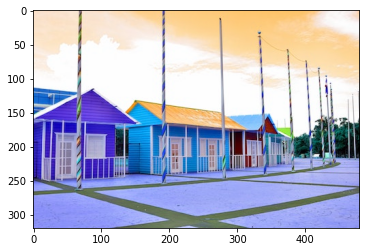

In [3]:
img_color = cv2.imread("images_doc/proc1-q3-color.jpeg")
plt.imshow(img_color)

(source de l'image: [PixaBay, Pexels](https://www.pexels.com/photo/apartment-architecture-block-blue-534124/))

### Q1.1

**a)** Ouvrez directement l'image dans un autre logiciel (le fichier se trouve dans images_doc/proc1-q3-color.jpeg) et comparez le résultat. Que remarquez vous ?

(réponse ici)<br>
Les couleurs sont inversées dans l'image

**b)** Affichez seulement le premier canal de couleurs de l'image. Pensez à analyser la composition de la matrice image que OpenCV vous retourne. Expliquez ensuite ce que vous voyez.

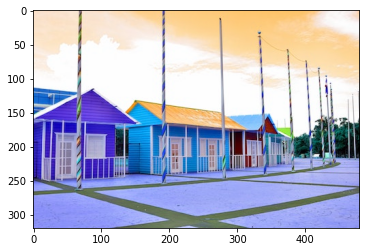

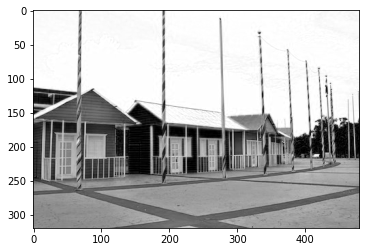

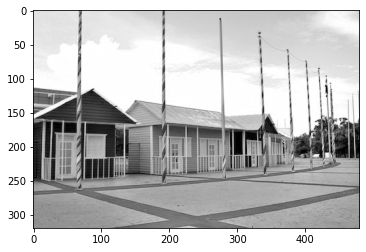

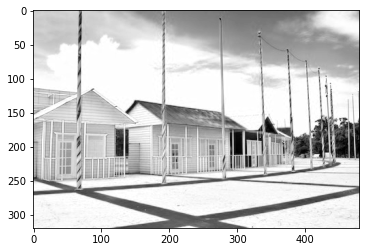

In [4]:
plt.imshow(img_color)              # Image originale
plt.figure()                       # Permet d'afficher plus d'une image dans la même cellule
plt.imshow(img_color[:, :, 0], cmap="gray") # Le paramètre cmap n'a pas d'effet sur une image à plus d'un canal.
plt.figure()                       # Permet d'afficher plus d'une image dans la même cellule
plt.imshow(img_color[:, :, 1], cmap="gray") # Le paramètre cmap n'a pas d'effet sur une image à plus d'un canal.
plt.figure()                       # Permet d'afficher plus d'une image dans la même cellule
plt.imshow(img_color[:, :, 2], cmap="gray") # Le paramètre cmap n'a pas d'effet sur une image à plus d'un canal.

**c)** Transformez maintenant l'image pour que les couleurs correspondent à ce que vous voyez en dehors de Jupyter.

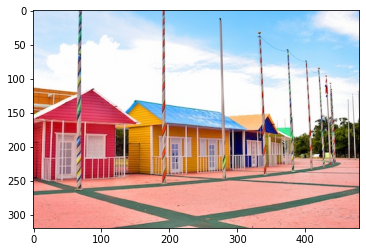

In [5]:
img_correcte = img_color.copy() # Permet de forcer une copie de l'image.
# img_correcte = img_color aurait modifié l'originale.
img_correcte[:, :, 2] = img_color[:, :, 0] # 0 correspond au canal rouge car c'est inversé
img_correcte[:, :, 0] = img_color[:, :, 2] # 2 correspond au canal bleu car c'est inversé
plt.imshow(img_correcte)
                                

### Q1.2

Soit cette couleur dans l'espace Y'CbCr (on suppose chaque valeur comme étant encodée sur 8 bits) :

$c = [100, 150, 150]$

Trouvez sa valeur équivalente dans l'espace RGB.

# Voir p.89 Eq(2.115)

In [6]:
c = np.array([100,150,150])

b = np.array([0,128,128])

A = np.array([[0.299,       0.587,      0.114],
              [-0.168736,   -0.331264,  0.5],
              [0.5,         -0.418688,  -0.081312]])
A_inv = np.linalg.inv(A)

RGB_values = A_inv @ (c - b)

print(RGB_values)

[130.84396413  76.71801966 138.98401039]


## Filtrage point à point

### Q2.1

Soit cette image (chargée par OpenCV et affichée par matplotlib): 

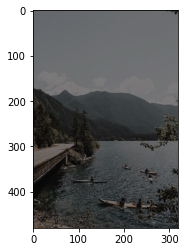

In [7]:
img_q31_org = cv2.imread("images_doc/proc2-q1-dock.jpeg")
img_q31_rgb = cv2.cvtColor(img_q31_org, cv2.COLOR_BGR2RGB) # Équivalent de la question Q1.1.c plus tôt.
plt.imshow(img_q31_rgb)

(Source de l'image originale : [Vlada Karpovich, Pexels](https://www.pexels.com/photo/snow-wood-landscape-mountains-4450090/))

Cette fonction affiche l'histogramme des trois composantes de l'image :

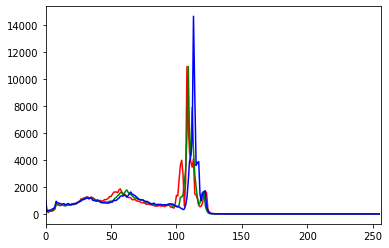

In [8]:
channels = ('r','g','b')
for i, col in enumerate(channels):
    hist = cv2.calcHist([img_q31_rgb], [i], None, [256], [0,256])
    plt.plot(hist,color = col)
    plt.xlim([0,256])

Ajustez la plage dynamique en luminosité de l'image pour qu'elle couvre l'ensemble des valeurs possibles.

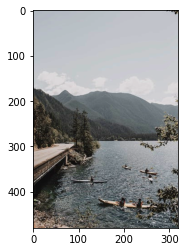

In [9]:
# NOTE: On convertit d'abord en float32 dans la plage [0,1] pour
# simplifier la manipulation des images avec des facteurs non-entiers.
# Matplotlib détecte ceci et affichera l'image correctement.
img_q31_f = np.float32(img_q31_rgb) / 255.0

min_value = np.min(img_q31_f)
max_value = np.max(img_q31_f) - min_value # Décale les valeurs vers 0 en soustractant le minimum.

img_q31_out = (img_q31_f - min_value) / max_value # On divise par max_value pour avoir une image entre 0 et 1. Value / max = ? / 1

plt.imshow(img_q31_out)

## Q2.2

Soit maintenant cette image :

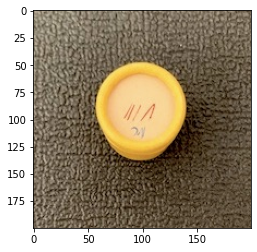

In [10]:
img_q32_org = cv2.imread("images_doc/proc2-q1-object.jpeg")
img_q32_rgb = cv2.cvtColor(img_q32_org, cv2.COLOR_BGR2RGB) # Équivalent de la question Q3.1.c de l'activité procédurale 1.
plt.imshow(img_q32_rgb)

Tentez de mettre en place un algorithme basé sur la luminosité permettant d'éliminer l'arrière-plan de cette image pour qu'il ne reste que l'objet en jaune sur un fond le plus noir possible.

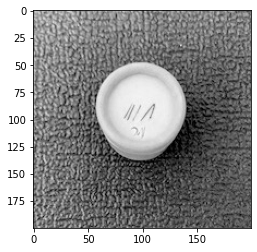

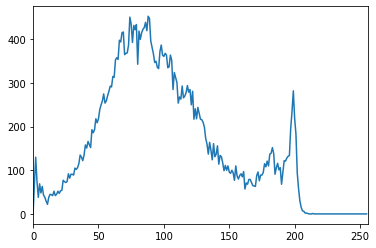

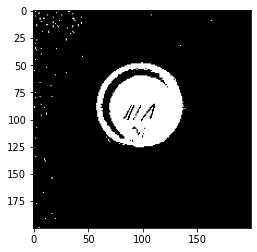

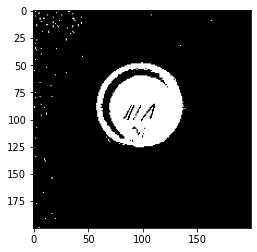

In [31]:
img_q32_filt = img_q32_rgb.copy()
W = img_q32_filt.shape[1] # NOTE: L'ordre des dimensions est Y puis X ("row-major")
H = img_q32_filt.shape[0]

grayImage = cv2.cvtColor(img_q32_filt, cv2.COLOR_BGR2GRAY)
plt.imshow(grayImage, cmap="gray")
plt.figure()

hist = cv2.calcHist([grayImage], [0], None, [256], [0,256])
plt.plot(hist)  # Permet de trouver le threshold à 170 en gris
plt.xlim([0,256])
  
(thresh, blackAndWhiteImage) = cv2.threshold(grayImage, 170, 255, cv2.THRESH_BINARY)
 
plt.figure()
plt.imshow(blackAndWhiteImage, cmap="gray")

# ou

for y in range(W):
    for x in range(H):
        if grayImage[x, y] > 170:
            blackAndWhiteImage[x, y] = 255
        else:
            blackAndWhiteImage[x, y] = 0

plt.figure()
plt.imshow(blackAndWhiteImage, cmap="gray")






## Filtrage linéaire

### Q3.1 

Soit l'image suivante ainsi que sa transformée de Fourier :

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x1f451f20160>)

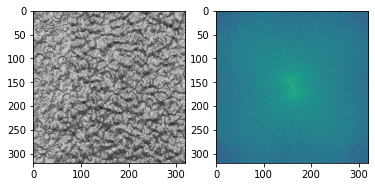

In [32]:
img_q4_org  = cv2.imread("images_doc/proc2-q2-texture.jpeg")
img_q4_mono = np.float32(cv2.cvtColor(img_q4_org, cv2.COLOR_BGR2GRAY)) / 255.0

def get_fft_mag(img):
    img_fft = np.fft.fft2(img)
    img_fft = np.fft.fftshift(img_fft)
    img_fft = 20*np.log(np.abs(img_fft))
    return img_fft
    
img_q4_fft = get_fft_mag(img_q4_mono)

plt.subplot(121),plt.imshow(img_q4_mono, cmap="gray")
plt.subplot(122),plt.imshow(img_q4_fft)

(Source de l'image originale : [Hoang Le, Pexels](https://www.pexels.com/photo/black-and-white-black-and-white-pattern-rough-978462/)).

**a)** Filtrez cette image à l'aide d'une convolution de façon à ce que la valeur de chaque pixel soit la valeur moyenne de ses voisins dans un carré de 15x15.

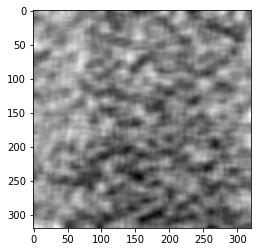

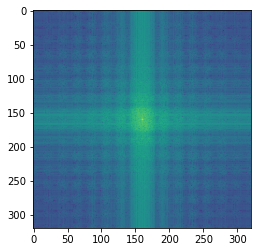

In [57]:
kernel_size = 15
filter_kernel = np.ones((kernel_size, kernel_size)) * (1/kernel_size**2)
#filter_kernel = np.array([
#  [0, -1, 0],
#  [-1, 5, -1],
#  [0, -1, 0]
#])
img_filt = cv2.filter2D(img_q4_mono, -1, filter_kernel)

img_q4_fft = get_fft_mag(img_filt)

plt.imshow(img_filt, cmap="gray")
plt.figure()
plt.imshow(img_q4_fft)


**b)** Comparez le résultat avec celui de la fonction cv2.GaussianBlur() avec un noyau de convolution de la même taille.

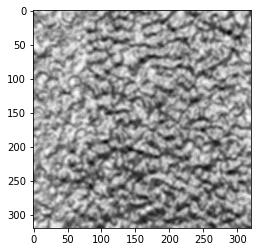

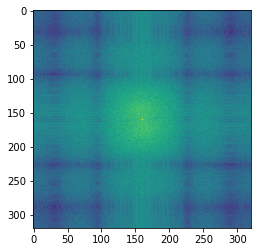

In [49]:
img_q4_blur = img_q4_mono.copy()
img_q4_gausblur = cv2.GaussianBlur(img_q4_blur, (15,15), cv2.BORDER_DEFAULT)

img_q4_fft = get_fft_mag(img_q4_gausblur)

plt.imshow(img_q4_gausblur, cmap="gray")
plt.figure()
plt.imshow(img_q4_fft)

**c)** Comment expliquez-vous la différence ?

*(réponse ici)*<br>
Il y a moins d'aliasing dans le résultat de la fonction GaussianBlur que dans la convolution.

### Q3.2

Utilisez un filtre linéaire pour extraire les contours de l'image fournie en Q3.2.

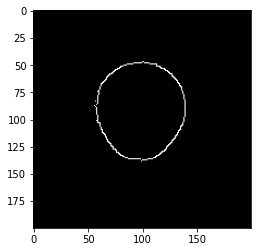

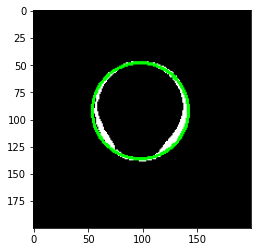

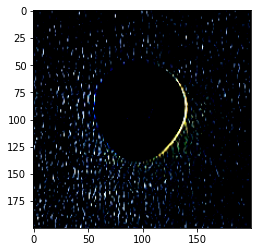

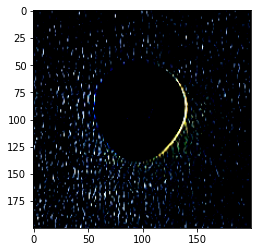

In [100]:
img_q32_contour = img_q32_rgb.copy()

img_q32_contour = cv2.GaussianBlur(img_q32_contour, (5,5), cv2.BORDER_DEFAULT)

img_q32_contour = cv2.Canny(img_q32_contour,100,200)

plt.imshow(img_q32_contour, cmap="gray")

# ou morphologyEx avec un cercle minimal vert

img_q32_contour = img_q32_rgb.copy()

img_q32_contour = cv2.GaussianBlur(img_q32_contour, (5,5), cv2.BORDER_DEFAULT)
img_q32_contour = cv2.cvtColor(img_q32_contour,cv2.COLOR_BGR2GRAY)

kernel = np.ones((5,5),np.uint8)
img_q32_contour = cv2.morphologyEx(img_q32_contour, cv2.MORPH_GRADIENT, kernel)

(thresh, img_q32_contour) = cv2.threshold(img_q32_contour, 70, 255, cv2.THRESH_BINARY)

# Fou un cercle minimal vert
contours,hierarchy = cv2.findContours(img_q32_contour, 1, 2)
cnt = contours[0]
(x,y),radius = cv2.minEnclosingCircle(cnt)
center = (int(x),int(y))
radius = int(radius)
img_q32_contour = cv2.cvtColor(img_q32_contour,cv2.COLOR_GRAY2RGB)
cv2.circle(img_q32_contour,center,radius,(0,255,0),2)

plt.figure()
plt.imshow(img_q32_contour, cmap="gray")

# ou Sobel
img_q32_contour = img_q32_rgb.copy()

k_sobel_y = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-2, -2, -2]
])

k_sobel_x = np.transpose(k_sobel_y)

img_q31_grad_x = cv2.filter2D(img_q32_contour, -1, k_sobel_x)
img_q31_grad_y = cv2.filter2D(img_q32_contour, -1, k_sobel_y)

plt.figure()
plt.imshow(img_q31_grad_x)
plt.figure()
plt.imshow(img_q31_grad_x)



## Filtrage morphologique et chaîne de traitement

### Q4.1 

À partir de l'image de la question Q1.2, combinez les filtres vus plus tôt pour ne conserver que le contour de l'objet de la figure (donc sans bruit de fond).

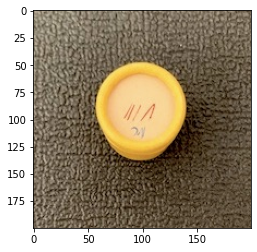

In [101]:
img_q32_clean = img_q32_rgb.copy()
# Déjà fait à la question 3.2
plt.imshow(img_q32_clean)